# Python Project: Heart diseases
_Pablo Martínez and Oriol Bustos_

## Imports

In [1]:
import pandas as pd
from tabula import read_pdf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import copy
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Slider, CustomJS, LinearColorMapper, CDSView, BooleanFilter, HoverTool
from bokeh.layouts import column
from bokeh.transform import factor_cmap, transform
from bokeh.palettes import Spectral10
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Contents
- [0. Load data](#0.-Load-data)
- [1. Columns](#1.-Columns)
- [2. Clean Up](#2.-Clean-Up)
- [3. Correlation between factors](#3.-Correlation-between-factors)
- [4. PCA](#4.-PCA)
- [5. Visualization](#5.-Visualization)

### Complete attribute documentation:
- 1 id: patient identification number
- 3 age: age in years
- 4 sex: sex (1 = male; 0 = female)
- 9 cp: chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- 10 trestbps: resting blood pressure (in mm Hg on admission to the 
        hospital)
- 12 chol: serum cholestoral in mg/dl
- 16 fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
- 19 restecg: resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST 
            elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy
            by Estes' criteria
- 32 thalach: maximum heart rate achieved
- 38 exang: exercise induced angina (1 = yes; 0 = no)
- 40 oldpeak = ST depression induced by exercise relative to rest
- 41 slope: the slope of the peak exercise ST segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
- 44 ca: number of major vessels (0-3) colored by flourosopy
- 51 thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
     
- predicted

## 0. Load data

We load the data from each file with its corresponding code specific for each format. In our case we are working with `.xslx`, `.csv` and `.pdf`.

In [2]:
df_H = pd.read_excel('datos\\Hungarian_Switzerland.xlsx', sheet_name=0)
df_S = pd.read_excel('datos\\Hungarian_Switzerland.xlsx', sheet_name=1)
df_Clev = pd.read_csv('datos\\processed.cleveland.data', header = None)
df_LB = read_pdf('datos\\LongBeachData.pdf', pages ='all') # we use tabula-py to read the data from a pdf

## 1. Columns homogeneization

In this cell we save a variable with the list of names we have, we need all of the dataframes to include these names in their headers to later correctly concatenate them.

In [3]:
column_names = ['id','age', 'sex', 'cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','predicted']  
print(type(df_H), type(df_S), type(df_Clev), type(df_LB))
print(len(column_names),len(df_H.columns), len(df_S.columns), len(df_Clev.columns), len(df_LB[0].columns))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'list'>
15 15 15 14 15


As we can see Cleveland has a column missing, which in this case corresponds to the ID's which we will create ourselves:

In [4]:
new_column_name = 'id'
new_column_value = [f'Patient {i+1}' for i in range(len(df_Clev))]
df_Clev.insert(0, new_column_name, new_column_value)

For Long Beach we have another problem: we have a list of 7 dataframes in which only the first one (df_LB[0]), has the correct header. The rest don't have a header at all, so the first row is automatically used as that. However, before substituting the header with the correct column names, in which case we would lose the first row for all the 6 patients, we need to duplicate this original header to keep the information.

In [5]:
df_LB_nohead = {}
for i, df in enumerate(df_LB[1:7]):
    header_row = [df.columns.tolist()]
    header_df = pd.DataFrame(header_row, columns=df.columns)
    df_with_header = pd.concat([header_df, df], ignore_index=True)
    df_LB_nohead[i] = df_with_header

Then we just substitute with the correct names:

In [6]:
df_S.columns = column_names
df_H.columns = column_names
df_Clev.columns = column_names
df_LB[0].columns = column_names
for _, df in df_LB_nohead.items():
    df.columns = column_names

We will concatenate later, it will be easier to clean data types independently for each dataframe.

## 2. Clean Up

### Putting df's from different hospitals into a list and adding hospital index
We will add a column = 'hospital_id' in which Switzerland patients = 1, Hungarian = 2, Cleveland = 3 and Long Beach = 4 

In [7]:
dataframes = [df_S, df_H, df_Clev, df_LB[0]] # los guardo en una lista todos para poder iterar sobre los dataframes
dataframes.extend(list(df_LB_nohead.values()))

In [8]:
print (dataframes)

[              id  age  sex  cp trestbps  chol fbs restecg thalach exang  \
0      Patient 1   32    1   1       95     0   ?       0     127     0   
1      Patient 2   34    1   4      115     0   ?       ?     154     0   
2      Patient 3   35    1   4        ?     0   ?       0     130     1   
3      Patient 4   36    1   4      110     0   ?       0     125     1   
4      Patient 5   38    0   4      105     0   ?       0     166     0   
..           ...  ...  ...  ..      ...   ...  ..     ...     ...   ...   
118  Patient 119   70    1   4      115     0   0       1      92     1   
119  Patient 120   70    1   4      140     0   1       0     157     1   
120  Patient 121   72    1   3      160     0   ?       2     114     0   
121  Patient 122   73    0   3      160     0   0       1     121     0   
122  Patient 123   74    1   2      145     0   ?       1     123     0   

    oldpeak slope ca thal  predicted  
0        .7     1  ?    ?          1  
1        .2     1  ?

In [8]:
def convert_to_int_or_nan(value):
    '''
    Function used later to **handle columns that should be ints or boolean but have decimals**, (no sabemos porque, pasa en pocas filas), 
    to convert them to values that can be used later with .astype()
    '''
    try:
        # First, try to convert to float
        float_val = float(value)
        # If successful, check if it's an integer or float
        if float_val.is_integer():
            # It's an integer, return as is
            return int(float_val)
        else:
            returnee = np.nan
            return returnee
    except (TypeError, ValueError) as e:
        returnee = np.nan
        return returnee

In the next loop we do the following: 
- Reset patient indices 
    - (right now each df goes from 1 to len(df), restarting every time)
- Add a column with origin hospital number
- Homogenize the types of data in each column

In [9]:
dataframes_clean_up = copy.deepcopy(dataframes) # copio la lista en una variable diferente para poder modificar la copia 
                                                # sin tocar el original. Así no hay que volver arriba cada vez q quieras recorrer

patients_counter = 0 # counter to assign an id to each patient from 0 to n=len(dataframes_concatenados)

# LOOPING OVER ALL DATAFRAMES BEFORE CONCATENATING
for df_index, df in enumerate(dataframes_clean_up):
    
    # Reset indices of patients
    for row_index, row in df.iterrows():
        
        patients_counter += 1 # cada fila sumamos 1 y lo usamos para rehacer los indices del dataset entero
                                # sino ahora mismo cada dataframe comienza por el Patient 1, 2, 3
        df['id'][row_index] = patients_counter # sustituimos lo que hay ahora por el numero
        
    # ADDING THE HOSPITAL INDEX
    if df_index<3:
        hospital_index = df_index+1
    else:
        hospital_index = 4 # to put index 4 for all the Long Beach df's
    
    new_column_name = 'hospital_id'
    new_column_value = [hospital_index for _ in range(len(df))]
    df.insert(14, new_column_name, new_column_value)

    print(df_index, row_index)
    
    ##################################################
    ##   HOMOGENIZE TYPES OF DATA FOR EACH COLUMN   ##
    ##################################################
    
    # REPLACE '?' with NaNs
    df.replace('?', pd.NA, inplace=True)
    
    # Convert to int 
    # not problematic columns, we will handle the others later
    convert2_int_columns = ['age', 'sex']
    for col in convert2_int_columns:
        df[col] = df[col].astype(int)
    
    # Convert to float
    convert2_float_columns = ['cp', 'trestbps', 'chol', 'restecg', 'thalach','oldpeak','chol', 'slope']
    for col in convert2_float_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce') # coerce fuerza a que convierta los errores en Nans
    
    # Convert to boolean
    convert2_boolean_columns = ['fbs','exang']
    for col in convert2_boolean_columns:
        for row_index, row_value in enumerate(df[col]):
            conv_value = convert_to_int_or_nan(row_value) # converts floats to Nans, we need to use the custom function
                                                    # as some give TypeError or ValueError
            df[col][row_index] = conv_value # save element-wise
        
        df[col] = df[col].astype('boolean') # now that we dont have floats,  we can convert ints and Nans all to boolean
    
    # Convert problematic ints
    # we can use the same custom solution as in boolean to the problematic floats 
    convert2_int_columns = ['ca', 'slope', 'predicted','thal']
    for col in convert2_int_columns:
        for row_index, row_value in enumerate(df[col]):
            conv_value = convert_to_int_or_nan(row_value) # converts floats to Nans
            df[col][row_index] = conv_value # save element-wise
        
        df[col] = df[col].astype('Int64')    
    
    print(df.dtypes)

C:\Users\pms20\AppData\Local\Temp\ipykernel_12716\1273587465.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id'][row_index] = patients_counter # sustituimos lo que hay ahora por el numero
C:\Users\pms20\AppData\Local\Temp\ipykernel_12716\1273587465.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][row_index] = conv_value # save element-wise
C:\Users\pms20\AppData\Local\Temp\ipykernel_12716\1273587465.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

0 122
id               int64
age              int32
sex              int32
cp               int64
trestbps       float64
chol             int64
fbs            boolean
restecg        float64
thalach        float64
exang          boolean
oldpeak        float64
slope            Int64
ca               Int64
thal             Int64
hospital_id      int64
predicted        Int64
dtype: object
1 293
id               int64
age              int32
sex              int32
cp               int64
trestbps       float64
chol           float64
fbs            boolean
restecg        float64
thalach        float64
exang          boolean
oldpeak        float64
slope            Int64
ca               Int64
thal             Int64
hospital_id      int64
predicted        Int64
dtype: object


C:\Users\pms20\AppData\Local\Temp\ipykernel_12716\1273587465.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][row_index] = conv_value # save element-wise
C:\Users\pms20\AppData\Local\Temp\ipykernel_12716\1273587465.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][row_index] = conv_value # save element-wise
C:\Users\pms20\AppData\Local\Temp\ipykernel_12716\1273587465.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

2 302


C:\Users\pms20\AppData\Local\Temp\ipykernel_12716\1273587465.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][row_index] = conv_value # save element-wise
C:\Users\pms20\AppData\Local\Temp\ipykernel_12716\1273587465.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][row_index] = conv_value # save element-wise


id               int64
age              int32
sex              int32
cp             float64
trestbps       float64
chol           float64
fbs            boolean
restecg        float64
thalach        float64
exang          boolean
oldpeak        float64
slope            Int64
ca               Int64
thal             Int64
hospital_id      int64
predicted        Int64
dtype: object
3 30
id               int64
age              int32
sex              int32
cp               int64
trestbps       float64
chol             int64
fbs            boolean
restecg          int64
thalach        float64
exang          boolean
oldpeak        float64
slope            Int64
ca               Int64
thal             Int64
hospital_id      int64
predicted        Int64
dtype: object
4 31
id               int64
age              int32
sex              int32
cp               int64
trestbps       float64
chol             int64
fbs            boolean
restecg        float64
thalach        float64
exang          bool

C:\Users\pms20\AppData\Local\Temp\ipykernel_12716\1273587465.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id'][row_index] = patients_counter # sustituimos lo que hay ahora por el numero
C:\Users\pms20\AppData\Local\Temp\ipykernel_12716\1273587465.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][row_index] = conv_value # save element-wise
C:\Users\pms20\AppData\Local\Temp\ipykernel_12716\1273587465.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

## Concatenate into a single Dataframe

The modified list is concatenated: 

In [10]:
df_sin_homogeneizar = pd.concat(dataframes, ignore_index=True)
df_concatenated = pd.concat(dataframes_clean_up, ignore_index=True)

In [14]:
df_concatenated

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hospital_id,predicted
0,1,32,1,1.0,95.0,0.0,<NA>,0.0,127.0,False,0.7,1,<NA>,<NA>,1,1
1,2,34,1,4.0,115.0,0.0,<NA>,NaN,154.0,False,0.2,1,<NA>,<NA>,1,1
2,3,35,1,4.0,NaN,0.0,<NA>,0.0,130.0,True,NaN,<NA>,<NA>,7,1,3
3,4,36,1,4.0,110.0,0.0,<NA>,0.0,125.0,True,1.0,2,<NA>,6,1,1
4,5,38,0,4.0,105.0,0.0,<NA>,0.0,166.0,False,2.8,1,<NA>,<NA>,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,0,4.0,127.0,333.0,True,1.0,154.0,False,0.0,<NA>,<NA>,<NA>,4,1
916,917,62,1,1.0,NaN,139.0,False,1.0,NaN,<NA>,NaN,<NA>,<NA>,<NA>,4,0
917,918,55,1,4.0,122.0,223.0,True,1.0,100.0,False,0.0,<NA>,<NA>,6,4,2
918,919,58,1,4.0,NaN,385.0,True,2.0,NaN,<NA>,NaN,<NA>,<NA>,<NA>,4,0


We execute .dtypes on the concatenated df, not only on the individuals, before and after the processing. If there are different types of data for a specific column, `object` will be printed, otherwise `float65`,`int64`,`bool`.

In [11]:
df_sin_homogeneizar.dtypes

id           object
age          object
sex          object
cp           object
trestbps     object
chol         object
fbs          object
restecg      object
thalach      object
exang        object
oldpeak      object
slope        object
ca           object
thal         object
predicted    object
dtype: object

In [12]:
df_concatenated.dtypes

id               int64
age              int32
sex              int32
cp             float64
trestbps       float64
chol           float64
fbs            boolean
restecg        float64
thalach        float64
exang          boolean
oldpeak        float64
slope            Int64
ca               Int64
thal             Int64
hospital_id      int64
predicted        Int64
dtype: object

We can see how all columns from the original df have mixed types, whereas after processing they are homogeneous.

### Counts

This print was just to see a list of frequencies for each type of value for each column for each patient. Eg. how many man(df['sex']=1), and womem (df['sex']=0) are there in Cleveland (df['hospital_id]=3).

In [13]:
columns_to_count = [ 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hospital_id',
       'predicted']

for df in dataframes_clean_up:
    for col in columns_to_count:
        counts = df[col].value_counts()
        hid = df['hospital_id'][0]
        print('###########################################################')
        print(f'Hospital ID: {hid}.\nColumn studied: {col}\nCounts:\n {counts}')
        print('###########################################################')
        print('\n\n\n')

###########################################################
Hospital ID: 1.
Column studied: age
Counts:
 61    9
56    8
53    8
51    7
62    7
38    6
60    6
57    6
63    5
59    5
50    4
52    4
65    4
55    4
47    4
54    3
43    3
58    3
64    3
46    2
66    2
68    2
42    2
69    2
70    2
67    1
72    1
73    1
32    1
34    1
48    1
45    1
41    1
40    1
36    1
35    1
74    1
Name: age, dtype: int64
###########################################################




###########################################################
Hospital ID: 1.
Column studied: sex
Counts:
 1    113
0     10
Name: sex, dtype: int64
###########################################################




###########################################################
Hospital ID: 1.
Column studied: cp
Counts:
 4    98
3    17
1     4
2     4
Name: cp, dtype: int64
###########################################################




###########################################################
Hospital ID: 1.
C

# 3. Correlation between factors

We will now explore the correlation between different factors among the dataset. The main tool that will be represented to assess these correlations are correlation matrixes. These matrixes allow to identify relationships between factors among the data (between the columns in the dataframe) and also to represent the strength of these relationships. The correlation coefficient runs values between the range of (-1,1), where 1 represents a perfect linear correlation, -1 a perfect inverse correlation and 0 no correlation between factors. 

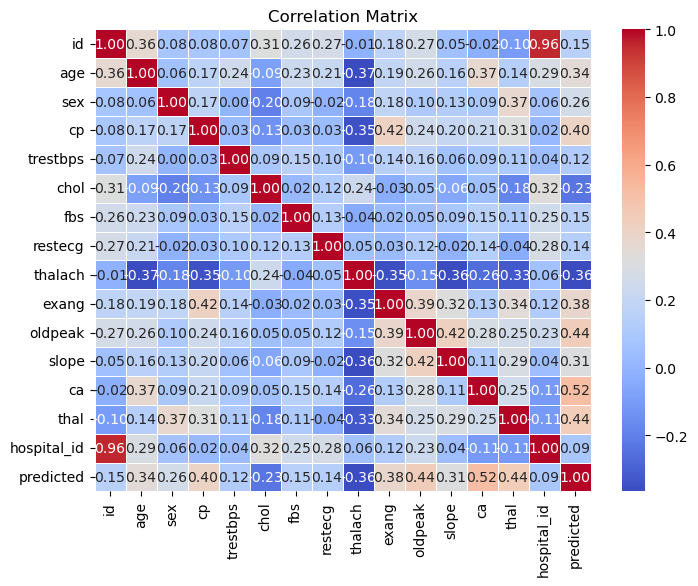

In [14]:
# to look at data correlations: 

correlation_matrix = df_concatenated.corr()
#para visualizar la matriz de correlaciones: 

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt=".2f", linewidths = 0.5)
plt.title('Correlation Matrix')
plt.show()   

As the amount of factors is very large, a good option to synthesize the most important correlations among factors with the predicted outcome of the patient, could be to highlight in a barplot the 10 highest correlations, which will reveal some interesting correlations in data factors. The diagram is obtained as it follows:  

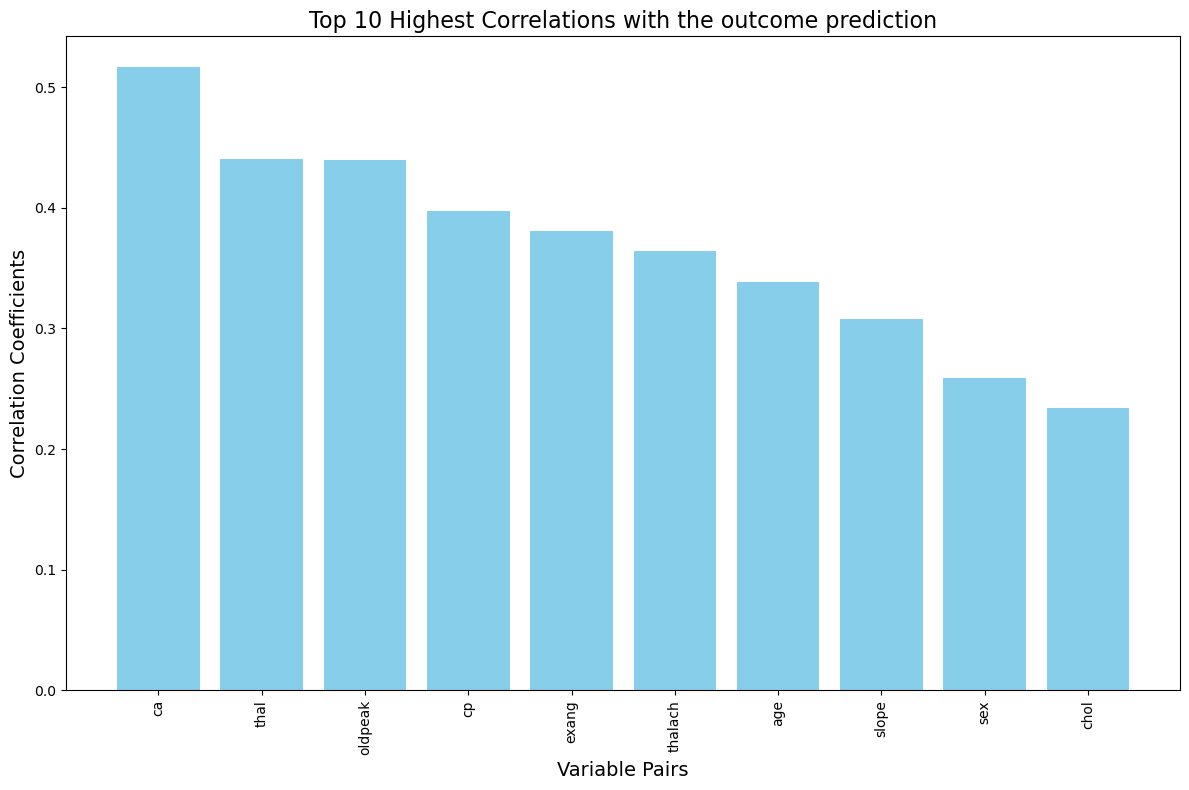

In [15]:
pred_correlations = correlation_matrix['predicted'].abs().sort_values(ascending=False)
pred_correlations = pred_correlations[pred_correlations.index != 'predicted']

fig, ax = plt.subplots(figsize=(12, 8)) 
bars = ax.bar(range(len(pred_correlations[:10])), pred_correlations[:10], color='skyblue')
ax.set_xlabel('Variable Pairs', fontsize=14)
ax.set_ylabel('Correlation Coefficients', fontsize=14)
ax.set_title('Top 10 Highest Correlations with the outcome prediction', fontsize=16)
ax.set_xticks(range(len(pred_correlations[:10])))
ax.set_xticklabels(pred_correlations[:10].index, rotation=90)
plt.subplots_adjust(bottom=0.4)
plt.tight_layout() 
plt.show()

After exploring all the correlations, there are 5 factors that apparently show a strong correlation with the predicted outcome of patients: 
   - the number of major vessels ('ca')
   - the maximum heart rate achieved ('thal')
   - the ST depression induced by exercise relative to rest ('oldpeak')
   - the chest pain type ('cp')
   - the exercise induced angina ('exang')

# Use factors to filter patients 

Once a general correlation study of the whole dataset is considered, the idea of using some selective factors to filter the dataframe by rows(patients) becomes interesting. To do that, the dataset is filtered by the hospital, age distribution and sex. 

In [16]:
df_concatenated
df_concatenated_hosp = df_concatenated.columns.get_loc('hospital_id')
print(df_concatenated_hosp)

14


## Filtering by hospital: 

The same procedure analysis done in the global dataset is done for every hospital data. The correlation matrix will be depicted and then the 10 most correlated factors towards the patient's outcome will be displayed. 

### Hungary: ###

In [17]:
df_hosp_H = df_concatenated.copy()
df_hosp_H

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hospital_id,predicted
0,1,32,1,1.0,95.0,0.0,<NA>,0.0,127.0,False,0.7,1,<NA>,<NA>,1,1
1,2,34,1,4.0,115.0,0.0,<NA>,NaN,154.0,False,0.2,1,<NA>,<NA>,1,1
2,3,35,1,4.0,NaN,0.0,<NA>,0.0,130.0,True,NaN,<NA>,<NA>,7,1,3
3,4,36,1,4.0,110.0,0.0,<NA>,0.0,125.0,True,1.0,2,<NA>,6,1,1
4,5,38,0,4.0,105.0,0.0,<NA>,0.0,166.0,False,2.8,1,<NA>,<NA>,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,0,4.0,127.0,333.0,True,1.0,154.0,False,0.0,<NA>,<NA>,<NA>,4,1
916,917,62,1,1.0,NaN,139.0,False,1.0,NaN,<NA>,NaN,<NA>,<NA>,<NA>,4,0
917,918,55,1,4.0,122.0,223.0,True,1.0,100.0,False,0.0,<NA>,<NA>,6,4,2
918,919,58,1,4.0,NaN,385.0,True,2.0,NaN,<NA>,NaN,<NA>,<NA>,<NA>,4,0


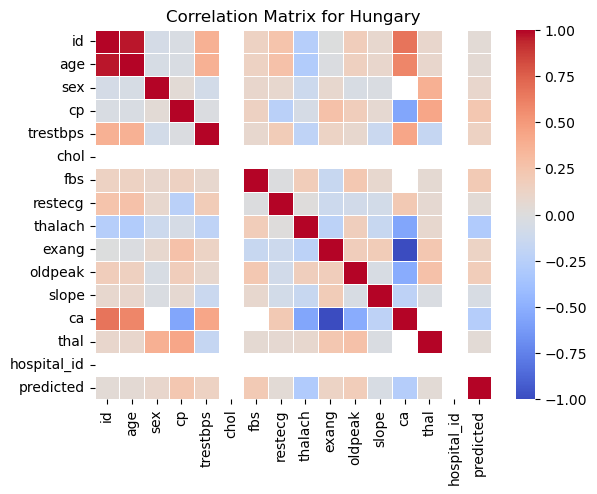

In [18]:
filas_seleccionadas_H = df_hosp_H[df_hosp_H['hospital_id'] == 1]
correlation_matrix_H = filas_seleccionadas_H.corr()
sns.heatmap(correlation_matrix_H, annot = False, cmap = 'coolwarm', fmt=".2f", linewidths = 0.5)
plt.title('Correlation Matrix for Hungary')

plt.show()

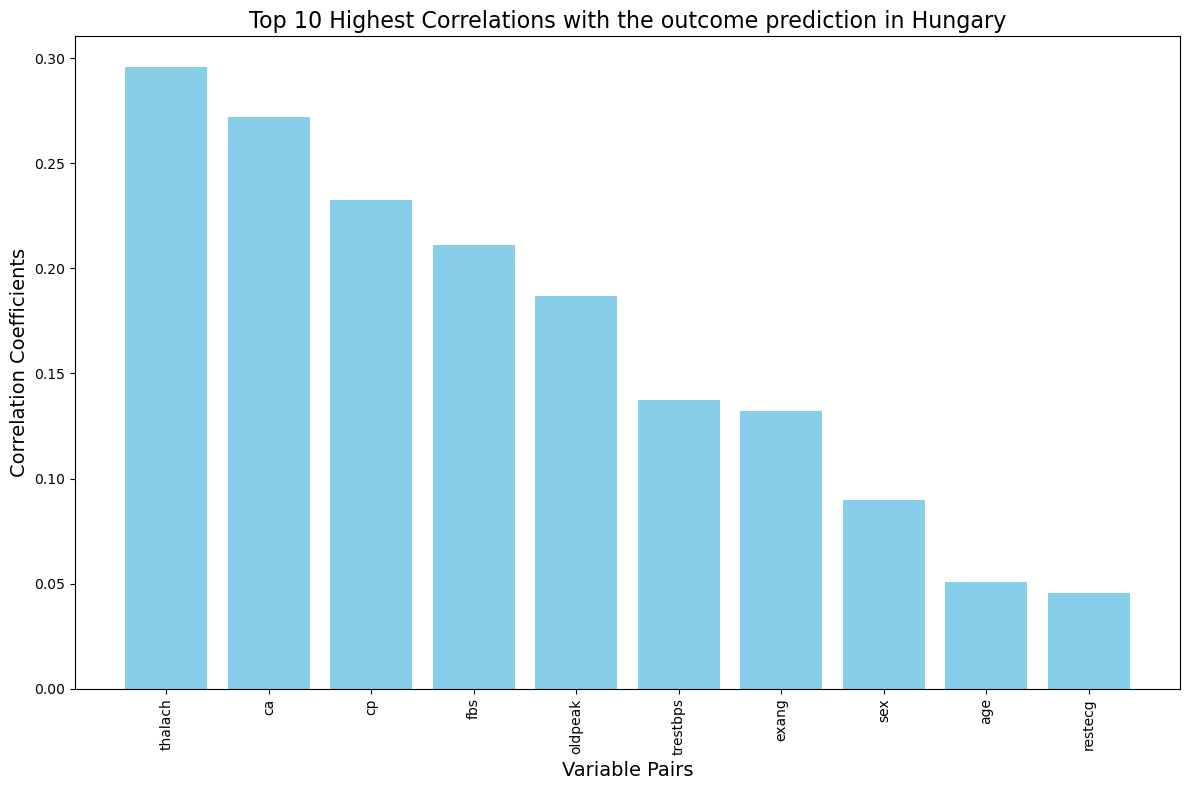

In [19]:
pred_correlations = correlation_matrix_H['predicted'].abs().sort_values(ascending=False)
pred_correlations = pred_correlations[pred_correlations.index != 'predicted']

fig, ax = plt.subplots(figsize=(12, 8)) 
bars = ax.bar(range(len(pred_correlations[:10])), pred_correlations[:10], color='skyblue')
ax.set_xlabel('Variable Pairs', fontsize=14)
ax.set_ylabel('Correlation Coefficients', fontsize=14)
ax.set_title('Top 10 Highest Correlations with the outcome prediction in Hungary', fontsize=16)
ax.set_xticks(range(len(pred_correlations[:10])))
ax.set_xticklabels(pred_correlations[:10].index, rotation=90)
plt.subplots_adjust(bottom=0.4)
plt.tight_layout() 
plt.show()

### Switzerland: ###

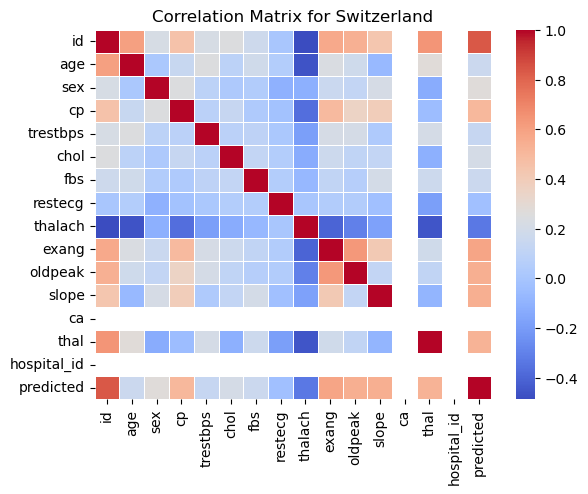

In [20]:
df_hosp_S = df_concatenated.copy()
filas_seleccionadas_S = df_hosp_S[df_hosp_S['hospital_id'] == 2]
correlation_matrix_S = filas_seleccionadas_S.corr()
sns.heatmap(correlation_matrix_S, annot = False, cmap = 'coolwarm', fmt=".2f", linewidths = 0.5)
plt.title('Correlation Matrix for Switzerland')

plt.show()

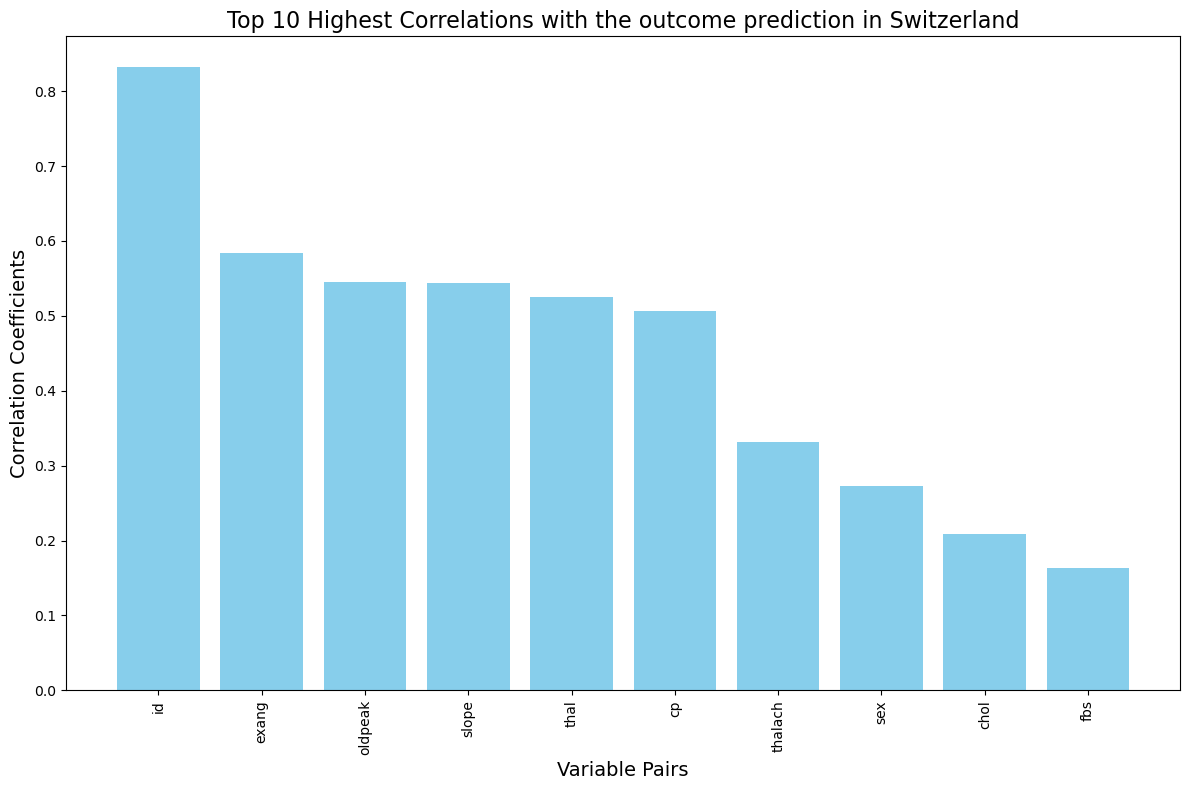

In [21]:
pred_correlations = correlation_matrix_S['predicted'].abs().sort_values(ascending=False)
pred_correlations = pred_correlations[pred_correlations.index != 'predicted']

fig, ax = plt.subplots(figsize=(12, 8)) 
bars = ax.bar(range(len(pred_correlations[:10])), pred_correlations[:10], color='skyblue')
ax.set_xlabel('Variable Pairs', fontsize=14)
ax.set_ylabel('Correlation Coefficients', fontsize=14)
ax.set_title('Top 10 Highest Correlations with the outcome prediction in Switzerland', fontsize=16)
ax.set_xticks(range(len(pred_correlations[:10])))
ax.set_xticklabels(pred_correlations[:10].index, rotation=90)
plt.subplots_adjust(bottom=0.4)
plt.tight_layout() 
plt.show()

### Cleveland: ###

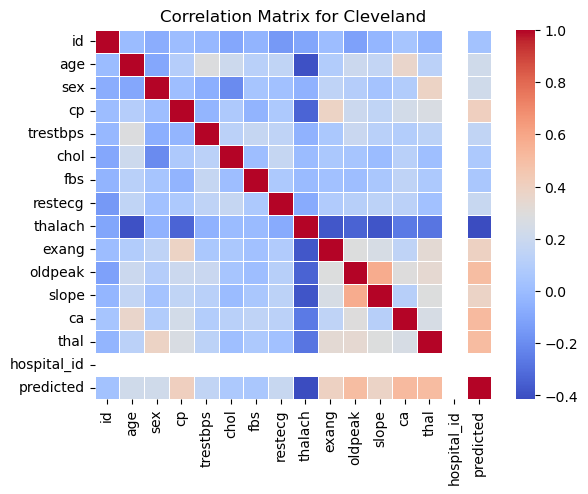

In [22]:
df_hosp_Clev = df_concatenated.copy() 
filas_seleccionadas_Clev = df_hosp_Clev[df_hosp_Clev['hospital_id'] == 3]
correlation_matrix_Clev = filas_seleccionadas_Clev.corr()
sns.heatmap(correlation_matrix_Clev, annot = False, cmap = 'coolwarm', fmt=".2f", linewidths = 0.5)
plt.title('Correlation Matrix for Cleveland')

plt.show()

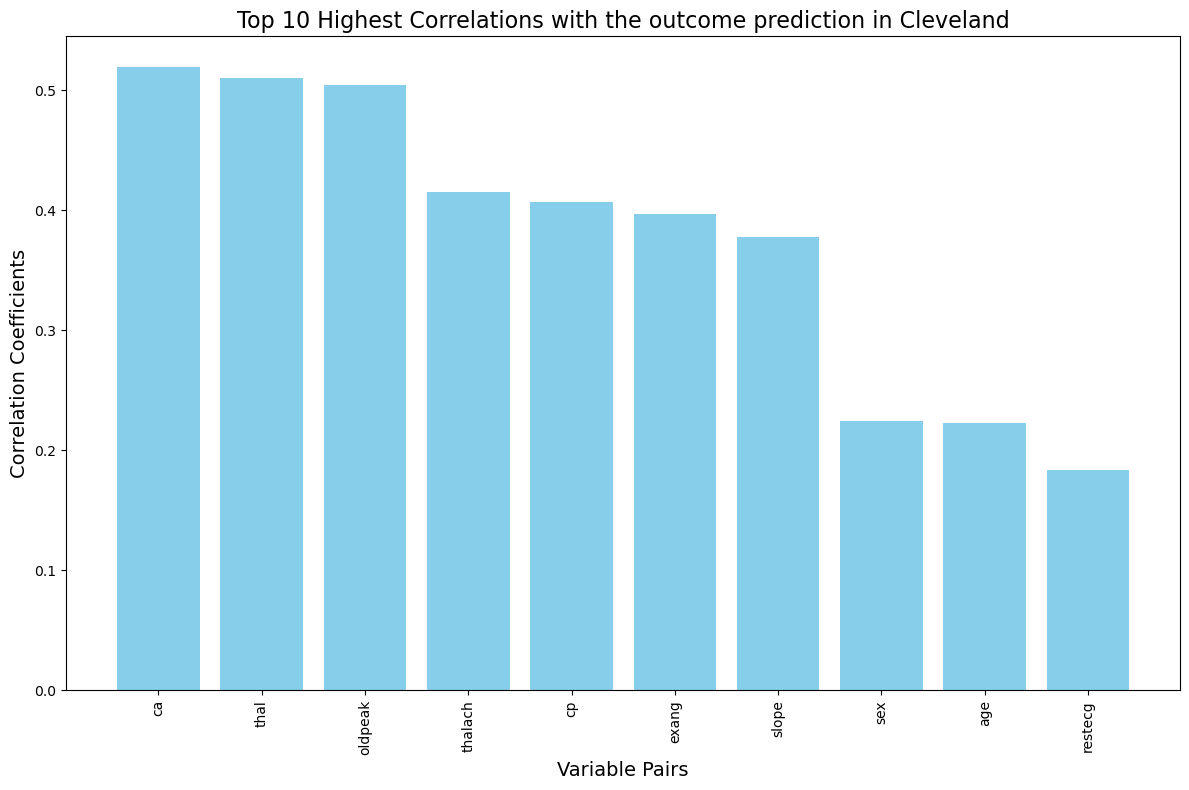

In [23]:
pred_correlations = correlation_matrix_Clev['predicted'].abs().sort_values(ascending=False)
pred_correlations = pred_correlations[pred_correlations.index != 'predicted']

fig, ax = plt.subplots(figsize=(12, 8)) 
bars = ax.bar(range(len(pred_correlations[:10])), pred_correlations[:10], color='skyblue')
ax.set_xlabel('Variable Pairs', fontsize=14)
ax.set_ylabel('Correlation Coefficients', fontsize=14)
ax.set_title('Top 10 Highest Correlations with the outcome prediction in Cleveland', fontsize=16)
ax.set_xticks(range(len(pred_correlations[:10])))
ax.set_xticklabels(pred_correlations[:10].index, rotation=90)
plt.subplots_adjust(bottom=0.4)
plt.tight_layout() 
plt.show()

### Long Beach: ### 

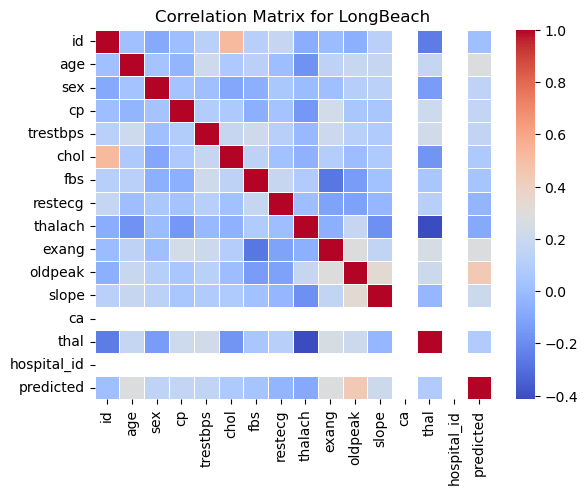

In [24]:
df_hosp_LB = df_concatenated.copy() 
filas_seleccionadas_LB = df_hosp_LB[df_hosp_LB['hospital_id'] == 4]
correlation_matrix_LB = filas_seleccionadas_LB.corr()
sns.heatmap(correlation_matrix_LB, annot = False, cmap = 'coolwarm', fmt=".2f", linewidths = 0.5)
plt.title('Correlation Matrix for LongBeach')

plt.show()

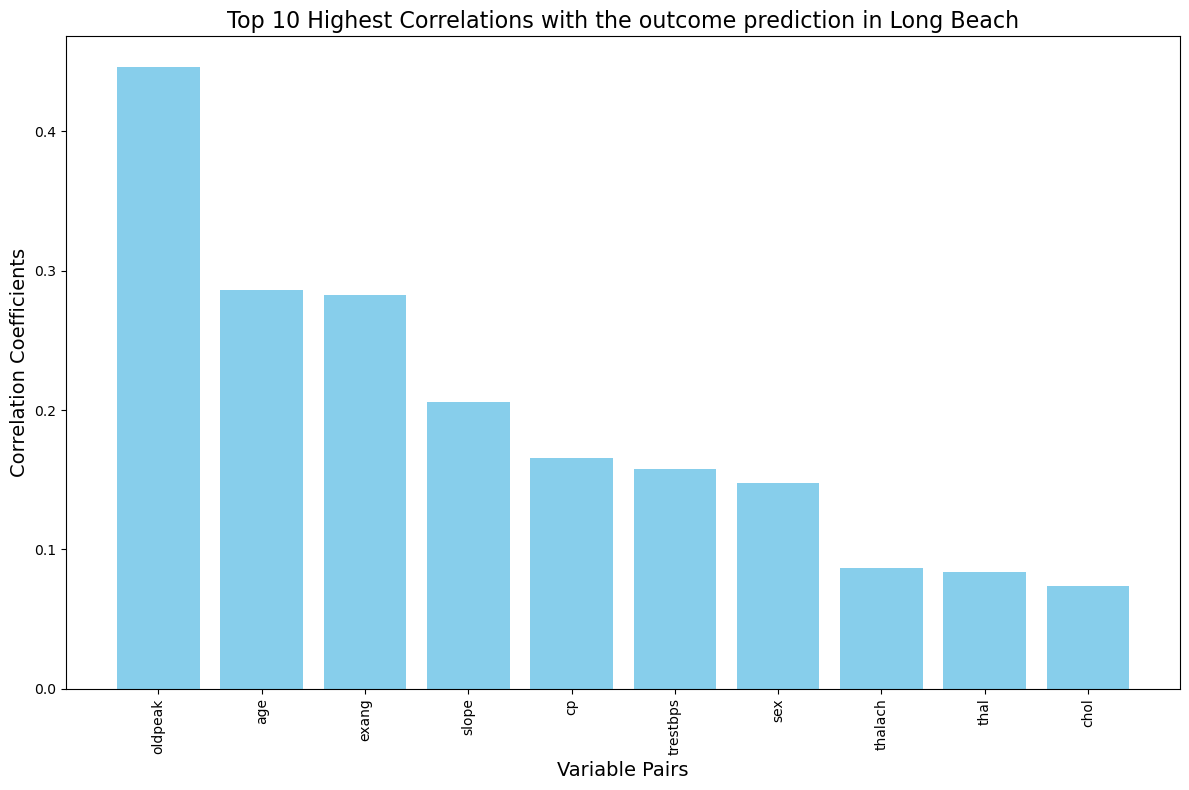

In [25]:
pred_correlations = correlation_matrix_LB['predicted'].abs().sort_values(ascending=False)
pred_correlations = pred_correlations[pred_correlations.index != 'predicted']

fig, ax = plt.subplots(figsize=(12, 8)) 
bars = ax.bar(range(len(pred_correlations[:10])), pred_correlations[:10], color='skyblue')
ax.set_xlabel('Variable Pairs', fontsize=14)
ax.set_ylabel('Correlation Coefficients', fontsize=14)
ax.set_title('Top 10 Highest Correlations with the outcome prediction in Long Beach', fontsize=16)
ax.set_xticks(range(len(pred_correlations[:10])))
ax.set_xticklabels(pred_correlations[:10].index, rotation=90)
plt.subplots_adjust(bottom=0.4)
plt.tight_layout() 
plt.show()

If one looks closely at the highest correlation values by hospital, they are ranked as follows: 

- Hungary: maximum heart rate achieved ('thalach')
- Switzerland: exercise induced angina ('exang')
- Cleveland: number of major vessels ('ca')
- Long Beach: the ST depression induced by exercise relative to rest ('oldpeak')

These results reveal that, depending on the hospital, the clinical outcome of the patient has very high correlations with different factors. Therefore, the hospital in which the patient is located will also be a relevant factor in assessing which factors are most related to the patient's clinical outcome. 

## Filtering by sex: ## 

The same procedure analysis done in the global dataset is done for different sex of the patients. The correlation matrix will be depicted and then the 10 most correlated factors towards the patient's outcome will be displayed. 

### For man: ###

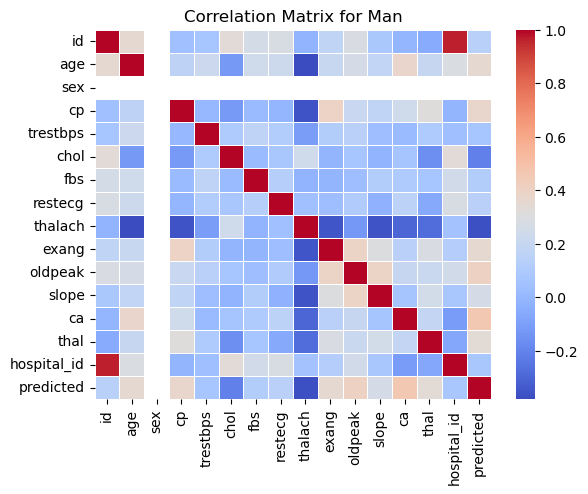

In [26]:
## esto es para ver como afecta el sexo a la correlación de los distintos factores: 

df_Masc = df_concatenated.copy()      
filas_seleccionadas_Masc = df_Masc[df_Masc['sex'] == 1]
correlation_matrix_Masc = filas_seleccionadas_Masc.corr()
sns.heatmap(correlation_matrix_Masc, annot = False, cmap = 'coolwarm', fmt=".2f", linewidths = 0.5)
plt.title('Correlation Matrix for Man')

plt.show()

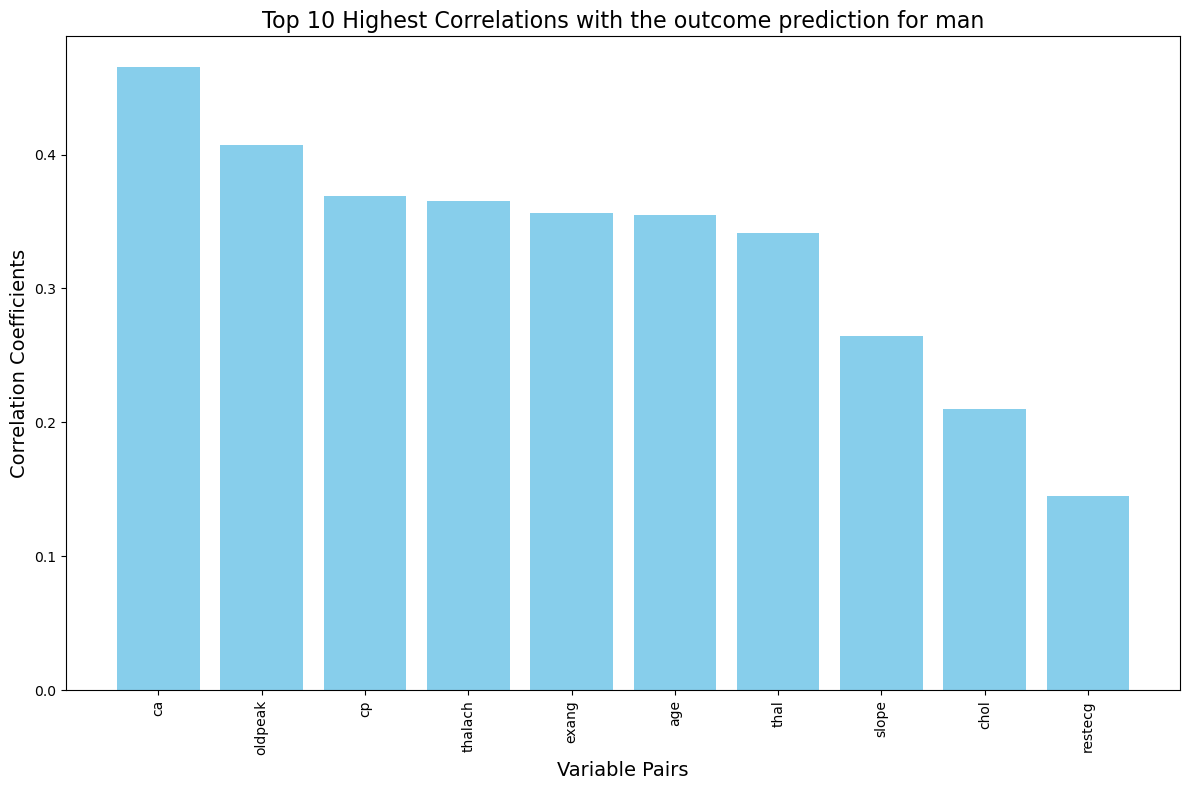

In [27]:
pred_correlations = correlation_matrix_Masc['predicted'].abs().sort_values(ascending=False)
pred_correlations = pred_correlations[pred_correlations.index != 'predicted']

fig, ax = plt.subplots(figsize=(12, 8)) 
bars = ax.bar(range(len(pred_correlations[:10])), pred_correlations[:10], color='skyblue')
ax.set_xlabel('Variable Pairs', fontsize=14)
ax.set_ylabel('Correlation Coefficients', fontsize=14)
ax.set_title('Top 10 Highest Correlations with the outcome prediction for man', fontsize=16)
ax.set_xticks(range(len(pred_correlations[:10])))
ax.set_xticklabels(pred_correlations[:10].index, rotation=90)
plt.subplots_adjust(bottom=0.4)
plt.tight_layout() 
plt.show()

### For woman: ###

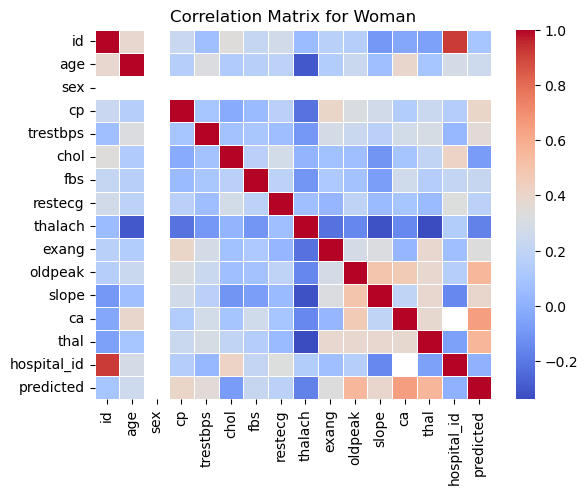

In [28]:
df_Fem  = df_concatenated.copy()
filas_seleccionadas_Fem = df_Fem[df_Fem['sex'] == 0]
correlation_matrix_Fem = filas_seleccionadas_Fem.corr()
sns.heatmap(correlation_matrix_Fem, annot = False, cmap = 'coolwarm', fmt=".2f", linewidths = 0.5)
plt.title('Correlation Matrix for Woman')

plt.show()

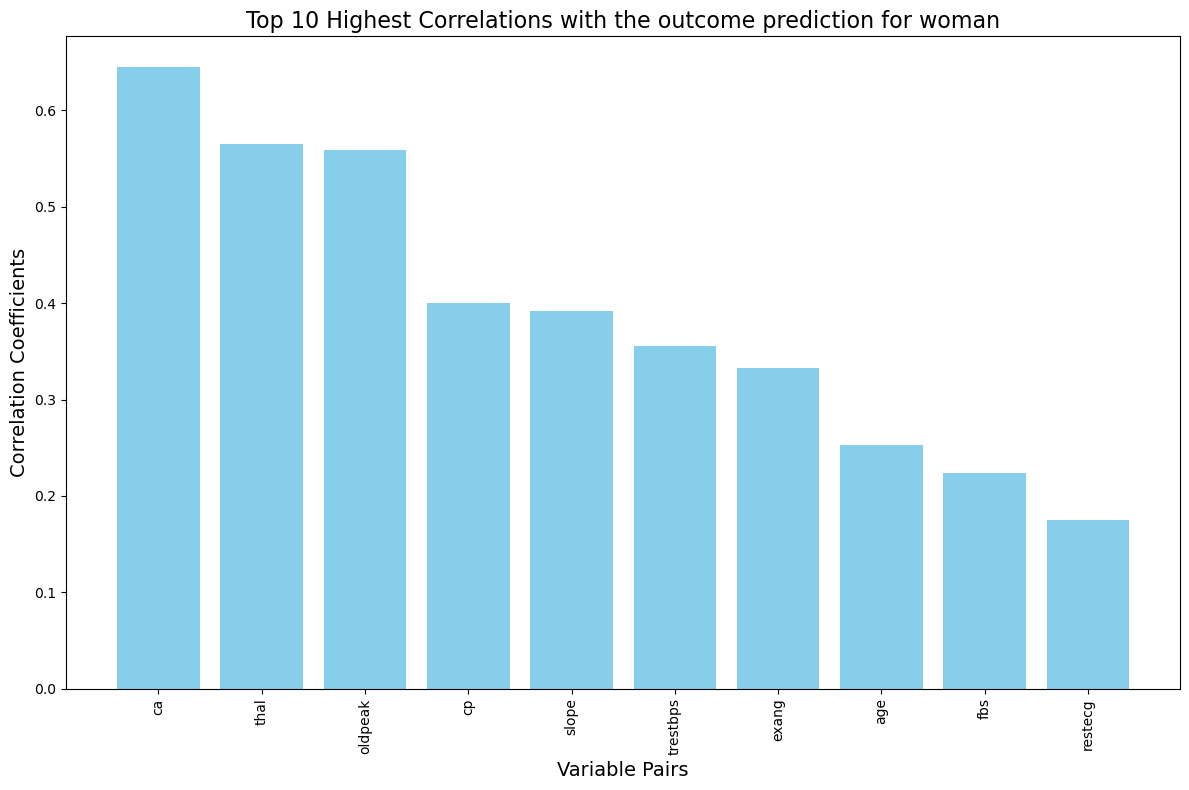

In [29]:
pred_correlations = correlation_matrix_Fem['predicted'].abs().sort_values(ascending=False)
pred_correlations = pred_correlations[pred_correlations.index != 'predicted']

fig, ax = plt.subplots(figsize=(12, 8)) 
bars = ax.bar(range(len(pred_correlations[:10])), pred_correlations[:10], color='skyblue')
ax.set_xlabel('Variable Pairs', fontsize=14)
ax.set_ylabel('Correlation Coefficients', fontsize=14)
ax.set_title('Top 10 Highest Correlations with the outcome prediction for woman', fontsize=16)
ax.set_xticks(range(len(pred_correlations[:10])))
ax.set_xticklabels(pred_correlations[:10].index, rotation=90)
plt.subplots_adjust(bottom=0.4)
plt.tight_layout() 
plt.show()

In the case of the gender comparison for the dataset, it is observed that for both categories the number of major vessels is the most important determinant of the patient's clinical status. 

However, as sub-candidates relevant factors, for men, we find factors such as the ST depression induced by exercise relative to rest, the chest pain type and the maximum heart rate achieved. On the other hand, for women, a different order of factors is found: the maximum heart rate achieved, the ST depression induced by exercise relative to rest and the chest pain type. 

Thus, it can be seen that there is quite a lot of similarity in terms of the factors that correlate the most with the clinical outcome of the patient. The main difference lies in the importance of these factors according to sex. 

## Filtering by age: ## 

The same procedure analysis done in the global dataset is done for different ages of the patients, splitting in young and old patients. The correlation matrix will be depicted and then the 10 most correlated factors towards the patient's outcome will be displayed. 

### For young patients: ###

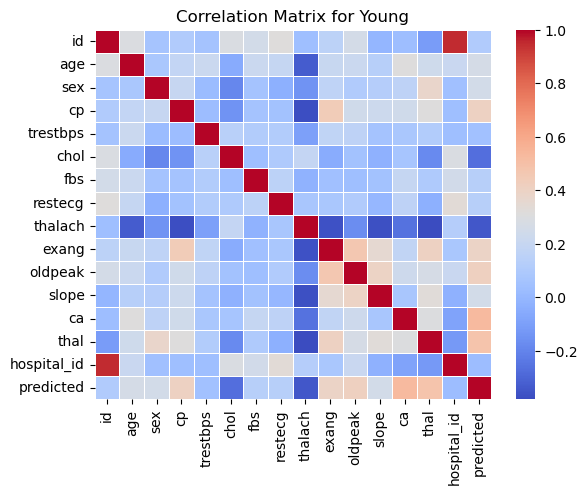

In [30]:
df_Young = df_concatenated.copy()      
filas_seleccionadas_Young = df_Young[df_Young['age'] <= 60]
correlation_matrix_Young = filas_seleccionadas_Young.corr()
sns.heatmap(correlation_matrix_Young, annot = False, cmap = 'coolwarm', fmt=".2f", linewidths = 0.5)
plt.title('Correlation Matrix for Young')

plt.show()

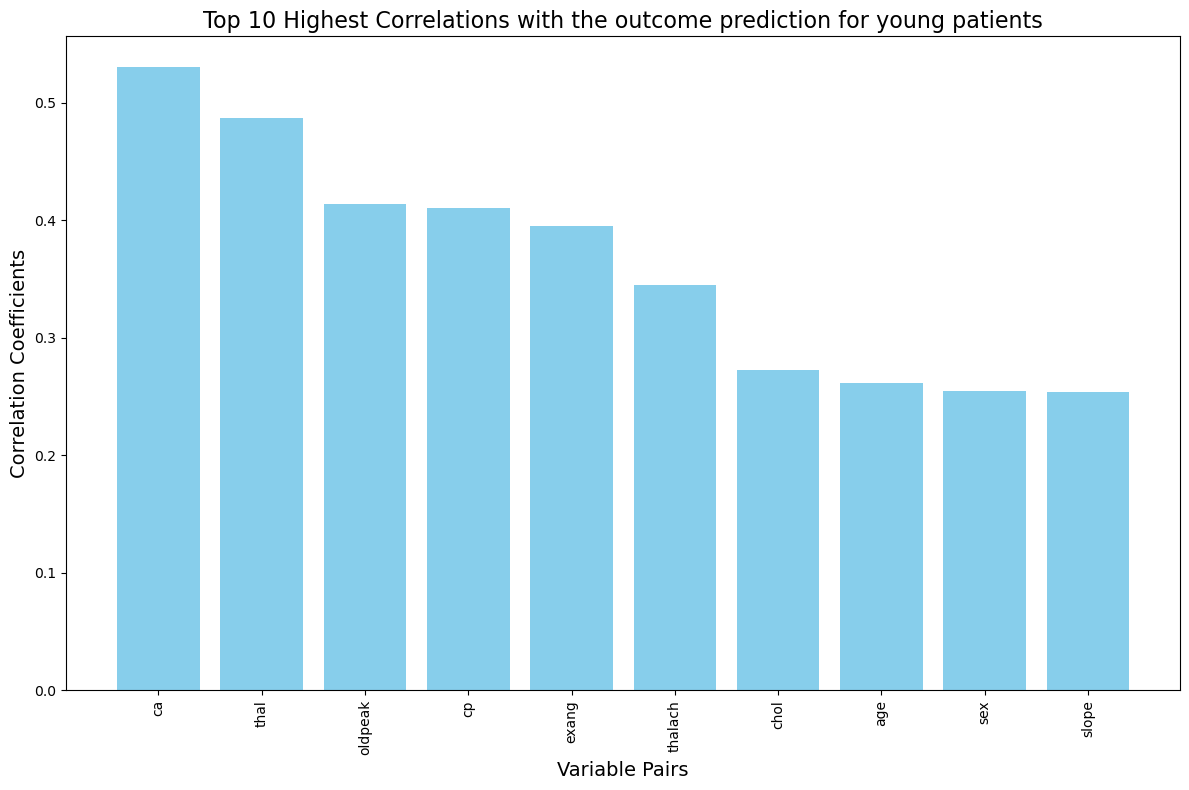

In [31]:
pred_correlations = correlation_matrix_Young['predicted'].abs().sort_values(ascending=False)
pred_correlations = pred_correlations[pred_correlations.index != 'predicted']

fig, ax = plt.subplots(figsize=(12, 8)) 
bars = ax.bar(range(len(pred_correlations[:10])), pred_correlations[:10], color='skyblue')
ax.set_xlabel('Variable Pairs', fontsize=14)
ax.set_ylabel('Correlation Coefficients', fontsize=14)
ax.set_title('Top 10 Highest Correlations with the outcome prediction for young patients', fontsize=16)
ax.set_xticks(range(len(pred_correlations[:10])))
ax.set_xticklabels(pred_correlations[:10].index, rotation=90)
plt.subplots_adjust(bottom=0.4)
plt.tight_layout() 
plt.show()

### For young patients: ###

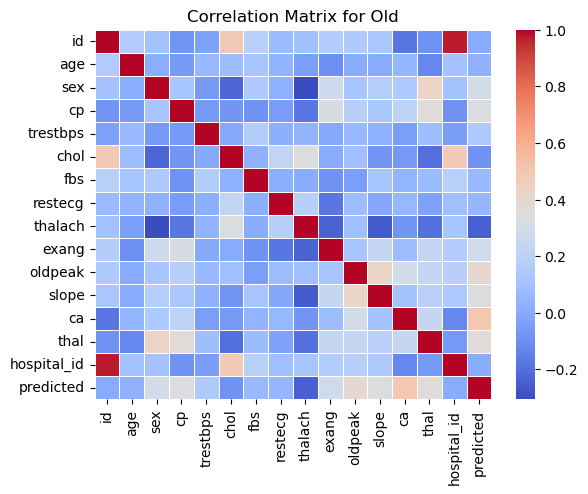

In [32]:
df_Old = df_concatenated.copy()
filas_seleccionadas_Old = df_Old[df_Old['age'] >= 60]
correlation_matrix_Old = filas_seleccionadas_Old.corr()
sns.heatmap(correlation_matrix_Old, annot = False, cmap = 'coolwarm', fmt=".2f", linewidths = 0.5)
plt.title('Correlation Matrix for Old')

plt.show()

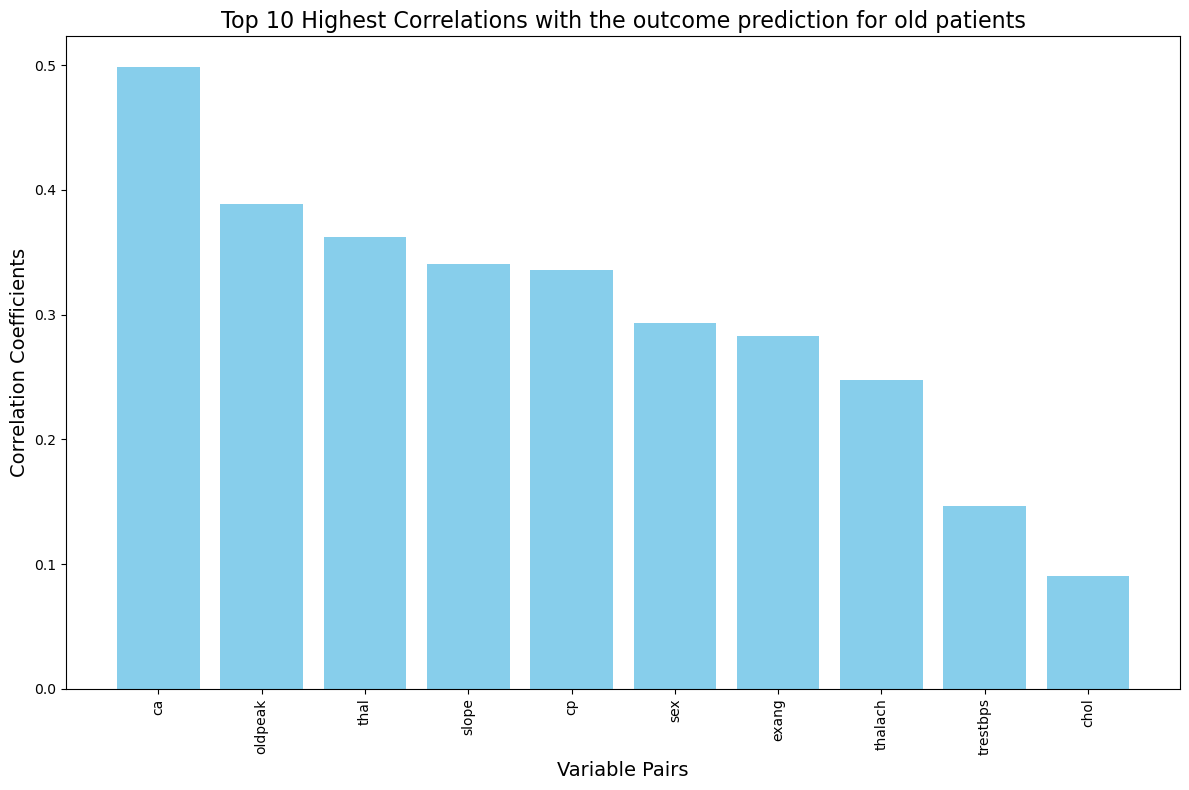

In [33]:
pred_correlations = correlation_matrix_Old['predicted'].abs().sort_values(ascending=False)
pred_correlations = pred_correlations[pred_correlations.index != 'predicted']

fig, ax = plt.subplots(figsize=(12, 8)) 
bars = ax.bar(range(len(pred_correlations[:10])), pred_correlations[:10], color='skyblue')
ax.set_xlabel('Variable Pairs', fontsize=14)
ax.set_ylabel('Correlation Coefficients', fontsize=14)
ax.set_title('Top 10 Highest Correlations with the outcome prediction for old patients', fontsize=16)
ax.set_xticks(range(len(pred_correlations[:10])))
ax.set_xticklabels(pred_correlations[:10].index, rotation=90)
plt.subplots_adjust(bottom=0.4)
plt.tight_layout() 
plt.show()

In the case of age distribution of dataset, the dataset is splitted in 2 and the results reveal a certain similarity on which are the most relevant factors. However, some factors which show high correlation for old patients such as the slope of the peak exercise ST segment doesn't seem to be that important in young population. 

# 4. PCA

Principal component analysis is a technique used to find which are the directions that maximize the variance among data and project the original data in these new dimensions. this technique looks for the data projection according to which the data is best represented according to least squares. Some principal components that are able to discriminate different data are created. In this case, PCA is used as a factorial analysis.  

## PCA done in sex groups: 

To perform the PCA the dataset has to be cleaned from the NAN values. The columns presenting a very large number of NAN's are deleted and all the rows containing this missing information are also avoided. 

In [34]:
df_no_columns = copy.deepcopy(df_concatenated)
columns_to_drop = ['fbs', 'slope', 'ca', 'thal']

df_no_columns = df_no_columns.drop(columns=columns_to_drop)
df_clean = df_no_columns.dropna()

df_clean['predicted'] = df_clean['predicted'].astype('float64')

C:\Users\pms20\AppData\Local\Temp\ipykernel_12716\1227886498.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['predicted'] = df_clean['predicted'].astype('float64')


In [35]:
df_sex = copy.deepcopy(df_clean)
df_sex.shape

(820, 12)

   Component  Explained Variance Ratio
0          1                  0.249425
1          2                  0.190884


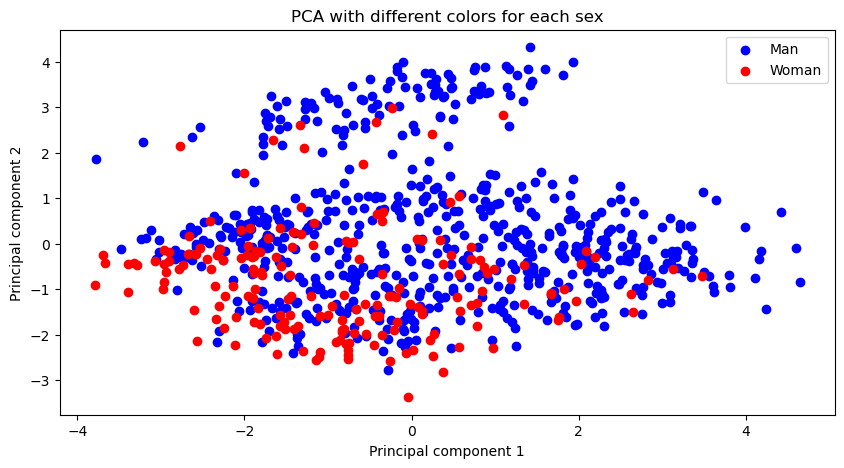

In [40]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_sex)

pca = PCA(n_components = 2)
pca.fit_transform(df_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
variance_df = pd.DataFrame({'Component': range(1, len(explained_variance_ratio) + 1),
                            'Explained Variance Ratio': explained_variance_ratio})
print(variance_df)

df_pca = pca.transform(df_scaled)

x_man = df_pca[df_sex['sex'] == 1]
x_woman = df_pca[df_sex['sex'] == 0]

plt.figure(figsize=(10,5))
plt.scatter(x_man[:,0], x_man[:,1], color = 'blue', label = 'Man')
plt.scatter(x_woman[:,0], x_woman[:,1], color = 'red', label = 'Woman')
plt.title('PCA with different colors for each sex')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.legend()
plt.show()

In the previous cell, the PCA analysis for different sex groups is performed. As it can be seen, the 2 principal components are able to spread man from woman patients with an explained variance which is pointed out in the table displayed above. To be more precise, the principal component 2 is the one that offers a better separation between sex groups.  

## PCA done in age groups: 

In [41]:
df_age = df_concatenated.copy()
columns_drop = ['fbs','slope','ca', 'thal']
df_age= df_age.drop(columns=columns_drop)
df_age = df_age.dropna()
df_age.shape

(820, 12)

   Component  Explained Variance Ratio
0          1                  0.249425
1          2                  0.190884


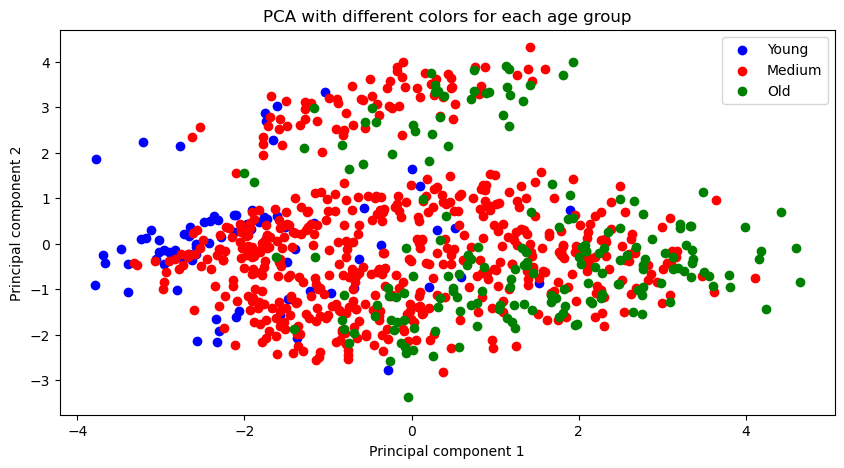

In [43]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_age)

pca = PCA(n_components = 2)
pca.fit_transform(df_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
variance_df = pd.DataFrame({'Component': range(1, len(explained_variance_ratio) + 1),
                            'Explained Variance Ratio': explained_variance_ratio})
print(variance_df)

df_pca = pca.transform(df_scaled)

x_young = df_pca[df_age['age'] <= 40]
x_medium = df_pca[(40 < df_age['age']) & (df_age['age'] <= 60)]
x_old= df_pca[df_age['age'] > 60]
plt.figure(figsize=(10,5))
plt.scatter(x_young[:,0], x_young[:,1], color = 'blue', label = 'Young')
plt.scatter(x_medium[:,0], x_medium[:,1], color = 'red', label = 'Medium')
plt.scatter(x_old[:,0], x_old[:,1], color = 'green', label = 'Old')
plt.title('PCA with different colors for each age group')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.legend()
plt.show()

Concerning the PCA for age distribution in data, it can be seen that Principal component number 1 is able to spread between young and old defined patients very clearly, as well as making a great difference of these 2 groups with the medium age group which occupies the majority of the plot. 

## PCA done in different hospitals: 

In [44]:
df_hosp = df_concatenated.copy()
columns_drop = ['fbs','slope','ca', 'thal']
df_hosp= df_hosp.drop(columns=columns_drop)
df_hosp = df_hosp.dropna()
df_hosp.shape

(820, 12)

   Component  Explained Variance Ratio
0          1                  0.249425
1          2                  0.190884


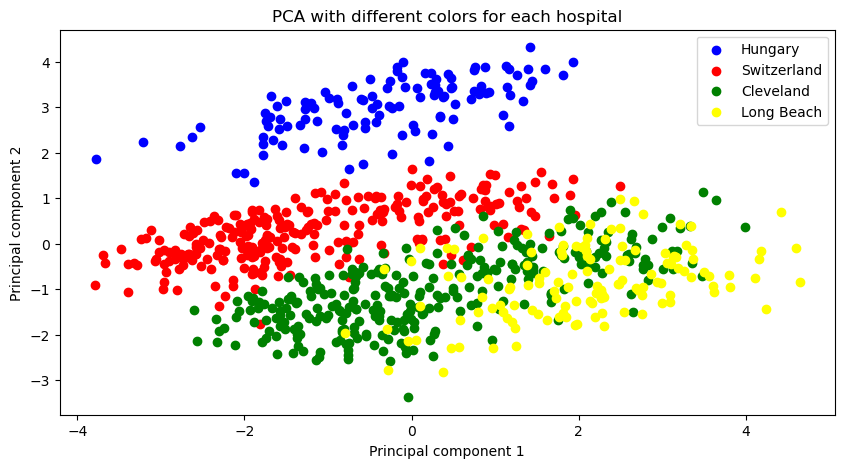

In [46]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_hosp)

pca = PCA(n_components = 2)
pca.fit_transform(df_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
variance_df = pd.DataFrame({'Component': range(1, len(explained_variance_ratio) + 1),
                            'Explained Variance Ratio': explained_variance_ratio})
print(variance_df)

df_pca = pca.transform(df_scaled)

x_H = df_pca[df_hosp['hospital_id'] == 1]
x_S = df_pca[df_sex['hospital_id'] == 2]
x_Clev = df_pca[df_sex['hospital_id'] == 3]
x_LB = df_pca[df_sex['hospital_id'] == 4]

plt.figure(figsize=(10,5))
plt.scatter(x_H[:,0], x_H[:,1], color = 'blue', label = 'Hungary')
plt.scatter(x_S[:,0], x_S[:,1], color = 'red', label = 'Switzerland')
plt.scatter(x_Clev[:,0], x_Clev[:,1], color = 'green', label = 'Cleveland')
plt.scatter(x_LB[:,0], x_LB[:,1], color = 'yellow', label = 'Long Beach')
plt.title('PCA with different colors for each hospital')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.legend()
plt.show()

In the case of different hospital patients, the PCA principal component 2 helps to spread the data between mainly Hungary, Switzerland and Cleveland in a pretty accurate way. Since Long Beach and Cleveland are a little bit overlapped in this princpal component, the principal component number 2 is able to spread correctly these 2 hospitals. 

# 5. Visualization 

We want to get the correlation for `thalach`-`predicted` for each age group for each hospital. So if we have 4 hospitals and 5 age groups we will get a matrix of 4x5 correlation values. We have to use the concatenated dataframe with the dropped columns and NaN rows.

In [38]:
df_clean.isnull().sum()

id             0
age            0
sex            0
cp             0
trestbps       0
chol           0
restecg        0
thalach        0
exang          0
oldpeak        0
hospital_id    0
predicted      0
dtype: int64

We need to divide in different age bins arbitrarily, so we will first take a look at the histogram.

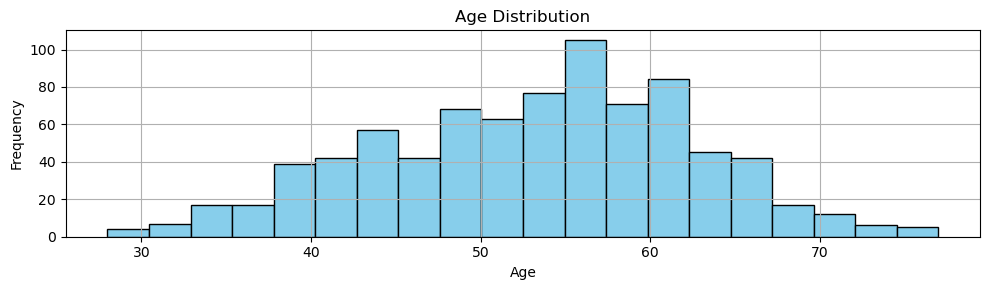

In [39]:
plt.figure(figsize=(10, 3))

# Create histogram of the 'age' column
plt.hist(df_clean['age'], bins=20, edgecolor='black', color='skyblue')

# Adding aesthetic improvements
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency') 
plt.grid(True)
plt.tight_layout()
plt.show()

To make sure all hospital have representation in all age groups we will need to be conservative and choose the lateral groups to include many values. For the middle ones we chose 5 years age difference.

In [40]:
age_groups = [(0, 40), (40, 45), (45, 50), (50, 55),(55, 60), (60, 100)]
hospital_ids = [1, 2, 3, 4]

age_group_labels = [f"{min_age}-{max_age}" for min_age, max_age in age_groups]

correlations_df = pd.DataFrame(columns=hospital_ids, index=age_group_labels)

for i, (min_age, max_age) in enumerate(age_groups):  # Loop that iterates over the list of 
                                                     # age groups and h_ids to impose both types of conditions
    for hospital_id in hospital_ids:
        group = df_clean[
            (df_clean['age'] > min_age) & 
            (df_clean['age'] <= max_age) & 
            (df_clean['hospital_id'] == hospital_id)
        ]
        
        correlation = group['thalach'].corr(group['predicted'])
        
        correlations_df.at[age_group_labels[i], hospital_id] = correlation # assign the new correlation value to its column and row
        
hospital_names = ['Switzerland','Hungarian', 'Cleveland', 'Long Beach']
correlations_df.columns = hospital_names

In [41]:
correlations_df

,Switzerland,Hungarian,Cleveland,Long Beach
0-40,-0.130462,-0.193097,-0.498977,0.167506
40-45,0.043855,-0.375705,-0.557551,-0.277815
45-50,0.297221,-0.219682,-0.536476,0.171088
50-55,-0.488376,-0.460634,-0.522764,0.074984
55-60,-0.438594,-0.089454,-0.299951,0.123102
60-100,-0.141454,-0.561638,-0.210913,-0.025457


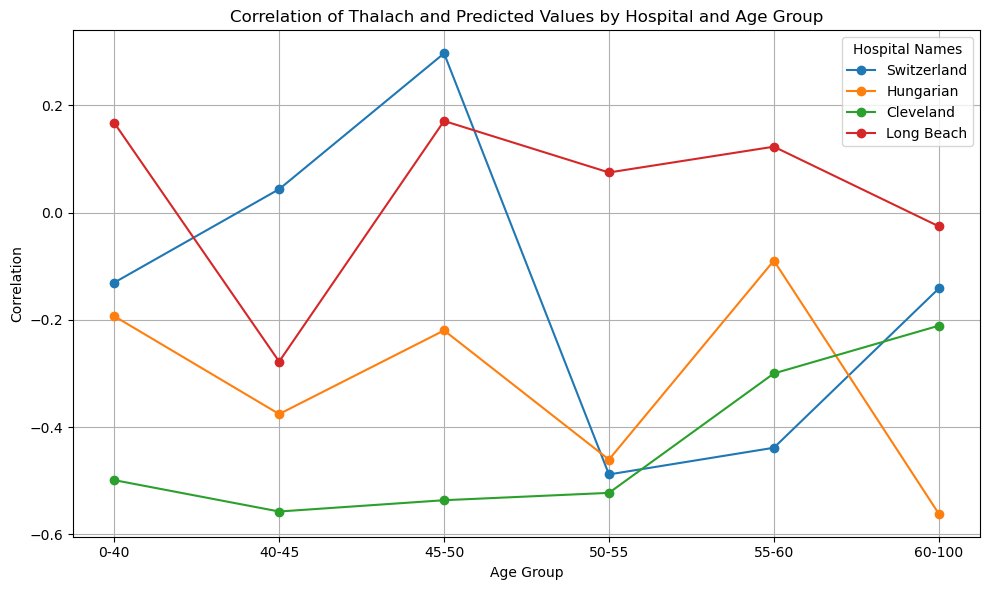

In [42]:
plt.figure(figsize=(10, 6))

# Plotting each column (hospital) and putting its label
for column in correlations_df.columns:
    plt.plot(correlations_df.index, correlations_df[column], marker='o', label=column)

plt.title('Correlation of Thalach and Predicted Values by Hospital and Age Group')
plt.xlabel('Age Group')
plt.ylabel('Correlation')
plt.grid(True)
plt.legend(title='Hospital Names')
plt.xticks()  
plt.tight_layout() 
plt.show()

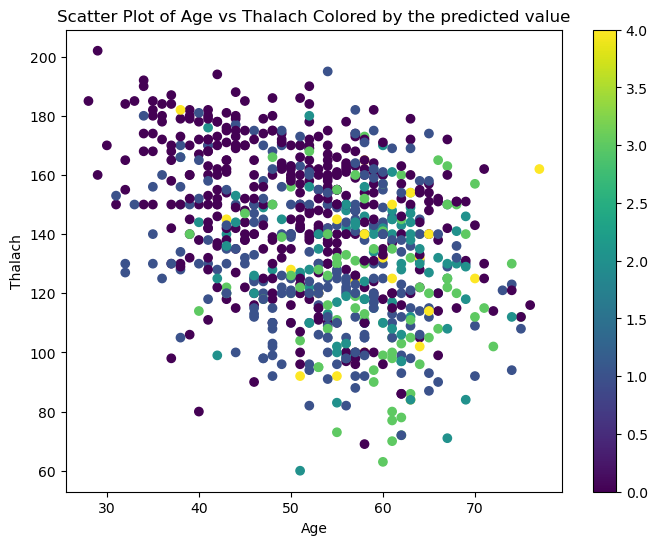

In [43]:
plt.figure(figsize=(8, 6))

plt.scatter(df_clean['age'], df_clean['thalach'], c=df_clean['predicted'])

plt.colorbar()

plt.xlabel('Age')
plt.ylabel('Thalach')
plt.title('Scatter Plot of Age vs Thalach Colored by the predicted value')
plt.show()

Here we are just remaking what we did before with the histogram.

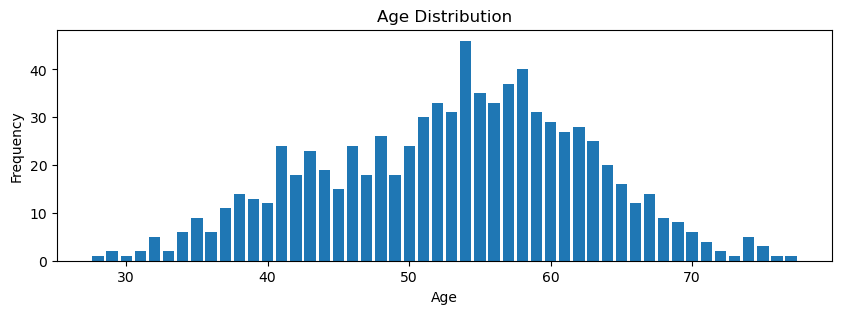

In [44]:
plt.figure(figsize=(10, 3))

age_counts = df_clean['age'].value_counts()

plt.bar(age_counts.index, age_counts.values)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

In [45]:
# Melt the DataFrame to long format, this reestructures the dataframe to 3 columns, index, age and hospital to then
# use the x='' and y='' inside sns.boxplot() to select the distribution we want to select
long_df = correlations_df.reset_index().melt(id_vars='index', var_name='Hospital', value_name='Correlations')
long_df

,index,Hospital,Correlations
0,0-40,Switzerland,-0.130462
1,40-45,Switzerland,0.043855
2,45-50,Switzerland,0.297221
3,50-55,Switzerland,-0.488376
4,55-60,Switzerland,-0.438594
5,60-100,Switzerland,-0.141454
6,0-40,Hungarian,-0.193097
7,40-45,Hungarian,-0.375705
8,45-50,Hungarian,-0.219682
9,50-55,Hungarian,-0.460634


Now we will do a boxplot that is displaying the dataset based on: the minimum, the maximum, the sample median, and the first and third quartiles. 
The data point that is located outside the domain of the box plot means it is outside 1.5 times the interquartile range above the upper quartile or below the lower quartile. We can see an example in Long Beach, which otherwise has very low variance compared to other hospitals. It is also quite separeted in terms of mean correlation, that being positive, while the rest are all negative. 

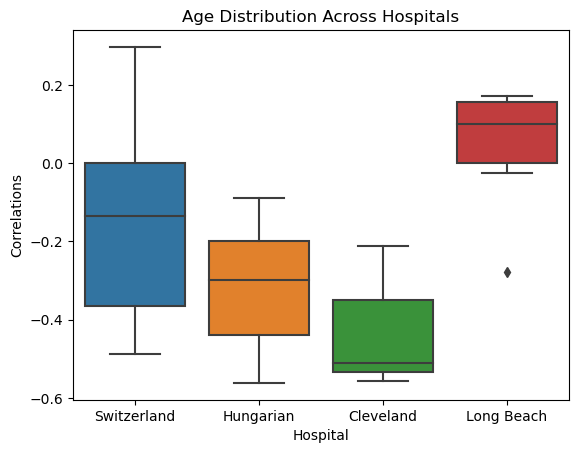

In [46]:
sns.boxplot(x='Hospital', y='Correlations', data=long_df)

plt.title('Age Distribution Across Hospitals')
plt.xlabel('Hospital')
plt.ylabel('Correlations')

plt.show()

Using some code from the internet we have adapted, an interactive plot is shown below, with which we can get info by hovering our mouse over the bars, and we can use a slider to delete bars and see only a part of them.

In [51]:
source = ColumnDataSource(long_df)

# Create a color map based on the unique hospitals
color_map = factor_cmap('Hospital', palette=Spectral10, factors=sorted(long_df['Hospital'].unique()))
p = figure(plot_width=800, plot_height=600, title="Correlation Coefficients by Age Group and Hospital",
           x_range=long_df['index'].unique(), tools="pan,box_zoom,reset,save")

# Put  the bars
bar = p.vbar(x='index', top='Correlations', source=source, width=0.7, color=color_map, legend_field='Hospital')

# Create the slider to filter the age group range
age_slider = Slider(start=0, end=100, value=0, step=5, title="Age Group")

# callback to filter the data based on the prrevious slider
callback = CustomJS(args=dict(source=source, slider=age_slider), code="""
    const data = source.data;
    const A = slider.value;
    const index = data['index'];
    const correlations = data['Correlations'];
    for (var i = 0; i < index.length; i++) {
        if (parseInt(index[i].split("-")[0]) >= A) {
            correlations[i] = correlations[i];
        } else {
            correlations[i] = Number.NaN; // Makes bars invisible if they don't match the criterion
        }
    }
    source.change.emit();
""")

age_slider.js_on_change('value', callback)
layout = column(age_slider, p)
show(layout)